**!!!**
Running of this notebook needs a lot of computing time (~3 hours), up to 32 GB of RAM and 2-3 GB of disk space. So it's not necessary to run it all. Just move to the end of notebook to **Prediction** paragraph and run notebook from there. You will get two submission files. One for simple convex combination of CB and LGB models and second for simple stacking model. 

# Import libraries

In [1]:
# for Kaggle
# !pip install -U lightautoml

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# edited by Mayur

import os
import re
import gc
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tqdm_notebook

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    # downcast_dtypes
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load necessary files

In [3]:
items = pd.read_csv("items.csv.zip")
item_categories = pd.read_csv("item_categories.csv")
sales_train = pd.read_csv("sales_train.csv.zip", parse_dates=['date'])
shops = pd.read_csv("shops.csv")
sales_test = pd.read_csv("test.csv.zip")
submission = pd.read_csv("sample_submission.csv.zip")

# for Kaggle

# PATH = '../input/competitive-data-science-predict-future-sales'

# items           = pd.read_csv(os.path.join(PATH,'items.csv'))
# item_categories = pd.read_csv(os.path.join(PATH,'item_categories.csv'))
# sales_train     = pd.read_csv(os.path.join(PATH,'sales_train.csv'), parse_dates=['date'])
# shops           = pd.read_csv(os.path.join(PATH,'shops.csv'))
# sales_test      = pd.read_csv(os.path.join(PATH,'test.csv'))
# submission      = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))

# drop duplicates
sales_train.drop_duplicates(inplace=True)

# add date_block_num feature to test df, set it value to 34
sales_test['date_block_num'] = 34
sales_test.date_block_num = sales_test.date_block_num.astype(np.int8)

# Research dataset

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


Does train dataset contains zeros?

In [5]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Research features

### item_cnt_day

(array([2.934458e+06, 1.204000e+03, 1.110000e+02, 3.100000e+01,
        1.100000e+01, 5.000000e+00, 4.000000e+00, 4.000000e+00,
        0.000000e+00, 8.000000e+00, 2.000000e+00, 1.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([ -22.   ,   32.775,   87.55 ,  142.325,  197.1  ,  251.875,
         306.65 ,  361.425,  416.2  ,  470.975,  525.75 ,  580.525,
         635.3  ,  690.075,  744.85 ,  799.625,  854.4  ,  909.175,
         963.95 , 1018.725, 1073.5  , 1128.275, 1183.05 , 1237.825,
        1292.6  , 1347.375, 1402.15 , 1456.925, 1511.7  , 1566.475,
        1621.25 , 

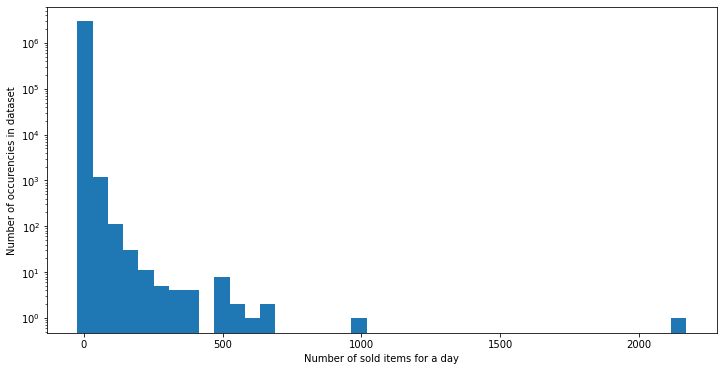

In [6]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of sold items for a day')
plt.ylabel('Number of occurencies in dataset')
plt.yscale('log')
plt.hist(sales_train.item_cnt_day, bins=40)

In [7]:
sales_train.item_cnt_day.describe()

count    2.935843e+06
mean     1.242641e+00
std      2.618837e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

Group number of sold items by date_block and plot.

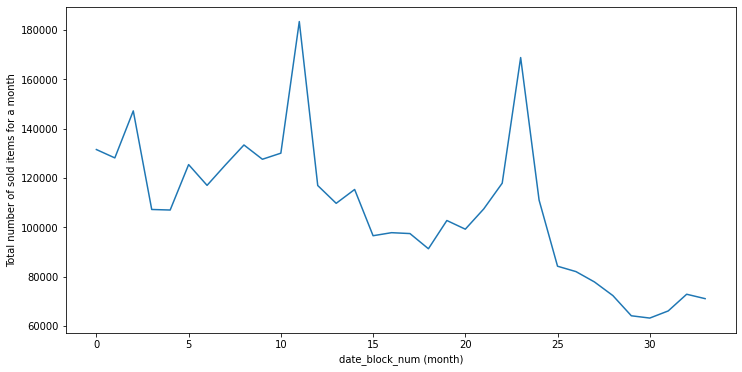

In [8]:
plt.figure(figsize=(12,6))
plt.xlabel('date_block_num (month)')
plt.ylabel('Total number of sold items for a month')
plt.plot(sales_train.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()['item_cnt_day'])

There is an obvious trend with peaks at New Year holidays.

### item_price

Distribution of items price and outliers

In [9]:
sales_train.item_price.describe()

count    2.935843e+06
mean     8.908535e+02
std      1.729801e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

<AxesSubplot:xlabel='item_price'>

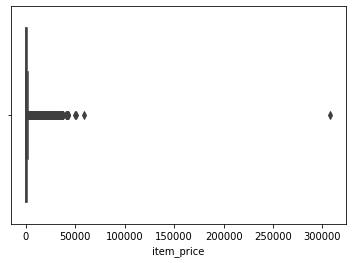

In [10]:
sns.boxplot(x='item_price', data=sales_train)

Majority of items has price lower than 5000.

### date_block_num

In [11]:
sales_train.date_block_num.describe()

count    2.935843e+06
mean     1.456991e+01
std      9.422992e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64

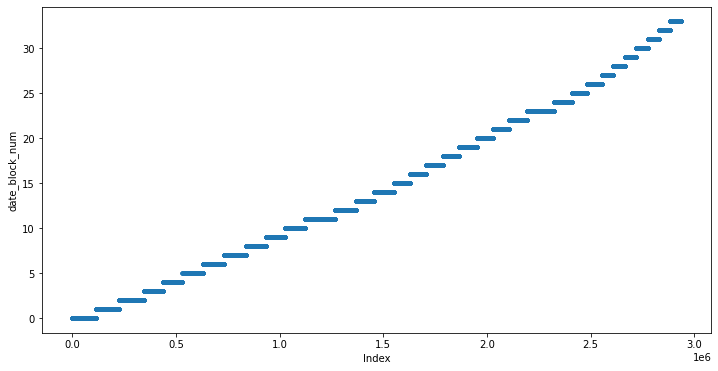

In [12]:
plt.figure(figsize=(12,6))
plt.xlabel('Index')
plt.ylabel('date_block_num')
plt.plot(sales_train.date_block_num, '.')

We can suppose, that dataset was built by concatenating of smaller datasets for each date block

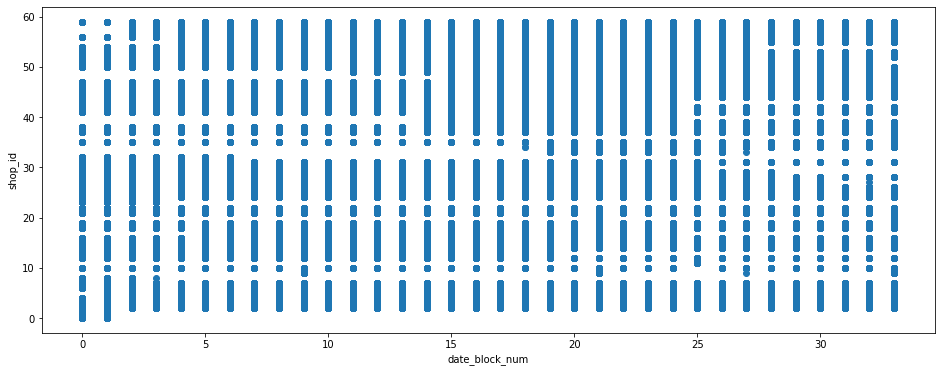

In [13]:
plt.figure(figsize=(16, 6))
plt.xlabel('date_block_num')
plt.ylabel('shop_id')
plt.scatter(sales_train.date_block_num, sales_train.shop_id)

### shop_id

What shops are presented in train set but aren't presented in the test set?

<AxesSubplot:>

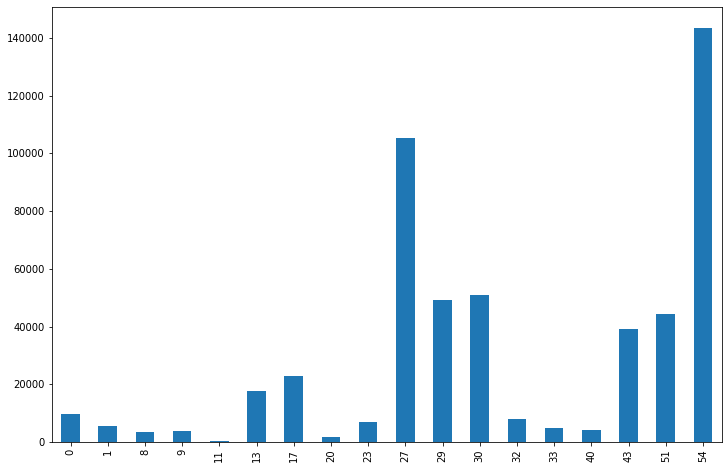

In [14]:
missed_ind = sorted([c for c in sales_train.shop_id.unique() if c not in sales_test.shop_id.unique()])
sales_train.shop_id.value_counts().sort_index().iloc[missed_ind].plot.bar(figsize=(12, 8))

Me may don't need shops with id's 8, 9, 11, 20 and 40. 

We can see strong vertical pattern. This means that data wasn't shaffled for shops. We also can see, that data for some shops and date blocks are missing.

# Fix errors in dataset

## Fix wrong shops id's

Some shop names look similar

In [15]:
print(shops.loc[shops.shop_id.isin([0, 57]), 'shop_name'])
print(shops.loc[shops.shop_id.isin([1, 58]), 'shop_name'])
print(shops.loc[shops.shop_id.isin([10, 11]), 'shop_name'])
print(shops.loc[shops.shop_id.isin([39, 40]), 'shop_name'])

0     !Якутск Орджоникидзе, 56 фран
57          Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1     !Якутск ТЦ "Центральный" фран
58          Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
10    Жуковский ул. Чкалова 39м?
11    Жуковский ул. Чкалова 39м²
Name: shop_name, dtype: object
39              РостовНаДону ТРК "Мегацентр Горизонт"
40    РостовНаДону ТРК "Мегацентр Горизонт" Островной
Name: shop_name, dtype: object


Let's correct this

In [16]:
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
sales_test.loc[sales_test.shop_id == 0, 'shop_id'] = 57

sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
sales_test.loc[sales_test.shop_id == 1, 'shop_id'] = 58

sales_train.loc[sales_train.shop_id == 11, 'shop_id'] = 10 # shop_id 11 isn't presented in the test set
sales_test.loc[sales_test.shop_id == 11, 'shop_id'] = 10

sales_train.loc[sales_train.shop_id == 40, 'shop_id'] = 39
sales_test.loc[sales_test.shop_id == 40, 'shop_id'] = 39

### Fix wrong prices

Some of prices may be wrong. Let's find them. At first we look for prices with big difference between min and max price for each item and find the most frequent normal prices for them.

In [17]:
# for each item get price with mode value > 5
def amode(col):
    i = 0
    res = 0
    count = col.value_counts().index
    while res <= 5 and i < len(count):
        res = count[i]
        i += 1
    return res

def alast(col):
    return res
    
# group train dataset by prices, aggregate by price mode
item_prices = sales_train[['item_id', 'item_price']].groupby('item_id').agg({'item_price': [np.min, 
                                                                                            np.max, 
                                                                                            amode]})
# add feature for difference between min and max prices
item_prices['price_diff'] = abs(item_prices.item_price.amax/item_prices.item_price.amin)

# get all prices with the difference between min and max prices more than 15 and min price less than 5
# save indexes of these prices
wrong_prices = item_prices[(item_prices.item_price.amin <= 5) & 
                           (item_prices.price_diff >= 15)].sort_values('price_diff', ascending=False)

wrong_prices.head()

item_price                    price_diff
              amin    amax   amode              
item_id                                         
11865         0.07   729.0   329.0  10414.285714
11857         0.10   729.0   319.0   7290.000000
11864         0.07   469.0   269.0   6700.000000
1836          0.50  2599.0  1999.0   5198.000000
1837          0.50  2599.0  1999.0   5198.000000

Fix wrong prices

In [18]:
for i_id in list(wrong_prices.index):
    sales_train.loc[(sales_train.item_id == i_id) & 
                    (sales_train.item_price <= 5), 'item_price'] = wrong_prices.loc[i_id, 'item_price'].amode
    
del wrong_prices
gc.collect()

59

### Fix wrong dates

Let's add year, month and day features and check if they are correct.

In [19]:
sales_train.date = pd.to_datetime(sales_train.date, format='%Y-%m-%d')
sales_train['year'] = sales_train.date.dt.year
sales_train['month'] = sales_train.date.dt.month
sales_train['day'] = sales_train.date.dt.day
sales_train[(sales_train.month == 1) & (sales_train.year == 2013) & sales_train.date_block_num > 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
115846,2013-01-02,1,50,3705,1499.00,2.0,2013,1,2
115861,2013-01-02,1,50,3745,799.00,1.0,2013,1,2
115946,2013-01-02,1,50,5262,719.52,1.0,2013,1,2
115979,2013-01-02,1,50,5272,399.56,1.0,2013,1,2
116070,2013-01-02,1,50,4886,899.00,1.0,2013,1,2
...,...,...,...,...,...,...,...,...,...
1267281,2013-01-12,11,46,4477,899.00,1.0,2013,1,12
1267430,2013-01-12,11,46,5620,590.00,1.0,2013,1,12
1267455,2013-01-12,11,46,5643,2490.00,1.0,2013,1,12
1267552,2013-01-12,11,46,5672,2590.00,1.0,2013,1,12


As we can see, some date values do not correspond to date_block_num values. Further investigation lead to conclusion, that this is because date values are wrong: day and month are confused with each other. Let's fix that.

In [20]:
def add_month(col):
    return int(divmod(col, 12)[1] + 1)

sales_train['month_from_date_block'] = sales_train.date_block_num.apply(add_month)

date_index = sales_train.loc[sales_train.month != sales_train.month_from_date_block].index

day = sales_train.loc[date_index, 'day']
month = sales_train.loc[date_index, 'month']

sales_train.loc[date_index, 'day'] = month
sales_train.loc[date_index, 'month'] = day

# fix date with correct month and year values
sales_train.date = sales_train.year.astype(str) + '-' + sales_train.month.astype(str) + '-' + sales_train.day.astype(str)
sales_train.date = pd.to_datetime(sales_train.date, format='%Y-%m-%d')

sales_train.drop(['month_from_date_block'], axis=1, inplace=True)

Group dataset by shop, item and date number.

# Investigate data distribution for train and test datasets.

In [21]:
sales_train_gr = sales_train.groupby(['date_block_num', 
                                      'shop_id', 'item_id'], as_index=False).agg({'item_price': 'mean', 
                                                                                  'item_cnt_day': 'sum'})

sales_train_gr.rename({'item_cnt_day': 'item_cnt_month'}, axis=1, inplace=True)

Let's investigate distribution of items and shops according to mean date block number.

Train dataset.

30

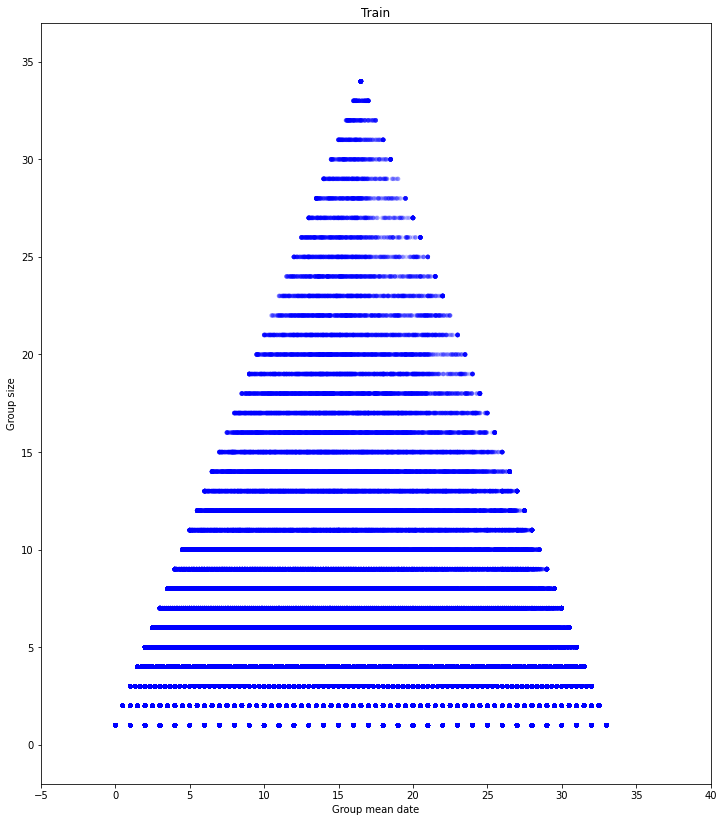

In [22]:
from matplotlib import pyplot as plt

g = sales_train_gr.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,14))
plt.scatter(g.date_block_num.mean(), g.size(), edgecolor = 'none', alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean date')
plt.ylabel('Group size')
plt.ylim(-2, 37)
plt.xlim(-5, 40)
plt.title('Train');

del sales_train_gr
gc.collect()

Test dataset

3323

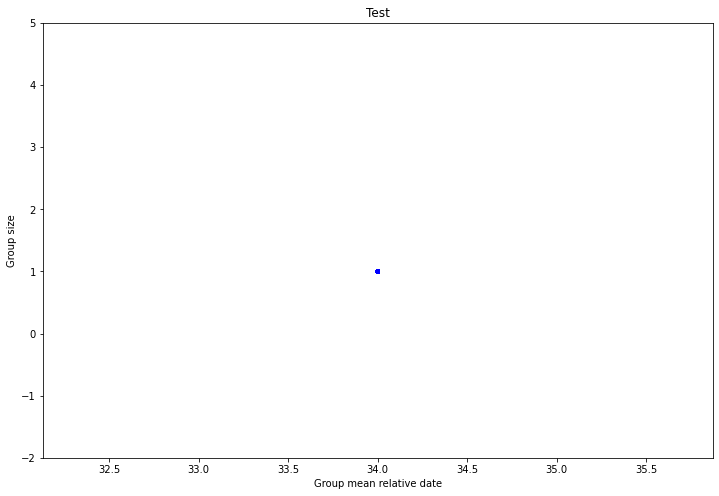

In [23]:
g = sales_test.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,8))
plt.scatter(g.date_block_num.mean(),g.size(),edgecolor = 'none',alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean relative date')
plt.ylabel('Group size')
plt.ylim(-2, 5)
plt.title('Test');

del g
gc.collect()

What does that mean? That mean that all groups in test dataset have size of one and labeled by 34th date block num, but that's not surprise for us.

But train dataset has groups with completely different sizes and completely different data. For groups in the top of our triangle we have information about all days, so, that's why their mean date is 16.5. For other groups we don't have full information, that's why their mean date becomes volatile.

Why does this happen? Let's investigate item_cnt_day feature in our dataset. 

In [24]:
sales_train.item_cnt_day.value_counts().sort_index().head(10)

-22.0          1
-16.0          1
-9.0           1
-6.0           2
-5.0           4
-4.0           3
-3.0          14
-2.0          78
-1.0        7252
 1.0     2629366
Name: item_cnt_day, dtype: int64

So, in the train dataset we find positive and negative values, but don't find zero. Our train dataset just doesn't include data with item_cnt_day equals to zero. So, we most add this combinations to our dataset and set item_cnt_month value for them to zero.

# Create all unique combinations of shop_id, item_id and date_block_num

In [25]:
%%time

from itertools import product

index_cols = ['date_block_num', 'shop_id', 'item_id']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[[block_num], cur_shops, cur_items])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales_train.groupby(index_cols, as_index=False).agg({'item_cnt_day': ['sum', 'nunique', 'count'], 
                                                          'item_price': 'mean', 
                                                          'day': ['first', 'last']
                                                         })

# rename columns in gb df
cols = list()
for c in gb.columns: 
    if c[0] == 'day':
        cols.append(c[1] + '_' + c[0])
    elif c[0] == 'item_cnt_day' and c[1] == 'sum':
        cols.append('item_cnt_month')
    elif c[0] == 'item_cnt_day' and c[1] == 'count':
        cols.append('item_deals_month')    
    elif c[0] == 'item_cnt_day' and c[1] == 'nunique':
        cols.append('sale_days_in_month')    
    else:
        cols.append(c[0])
        
gb.columns = cols

#join aggregated data to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols)

# add test data
all_data = all_data.append(pd.merge(sales_test, gb, how='left', on=index_cols))

#sort the data
all_data.sort_values(index_cols, inplace=True)

# reset index for the new dataset
all_data.reset_index(inplace=True, drop=True)

# drop ID column
all_data.drop('ID', axis=1, inplace=True)

# flll NaN values
all_data.fillna(0, inplace=True)

# downcast some dataset columns
all_data['date_block_num'] = all_data['date_block_num'].astype(np.int8)
all_data['shop_id'] = all_data['shop_id'].astype(np.int8)
all_data['item_id'] = all_data['item_id'].astype(np.int16)
all_data = downcast_dtypes(all_data)

# clean memory
del sales_test, grid, gb
gc.collect()

all_data.head()

CPU times: user 11.5 s, sys: 1.6 s, total: 13.1 s
Wall time: 12.6 s


,date_block_num,shop_id,item_id,item_cnt_month,sale_days_in_month,item_deals_month,item_price,first_day,last_day
0,0,2,19,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,27,1.0,1.0,1.0,2499.0,11.0,11.0
2,0,2,28,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,29,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,32,0.0,0.0,0.0,0.0,0.0,0.0


Distribution of items for each shop

<AxesSubplot:xlabel='shop_id'>

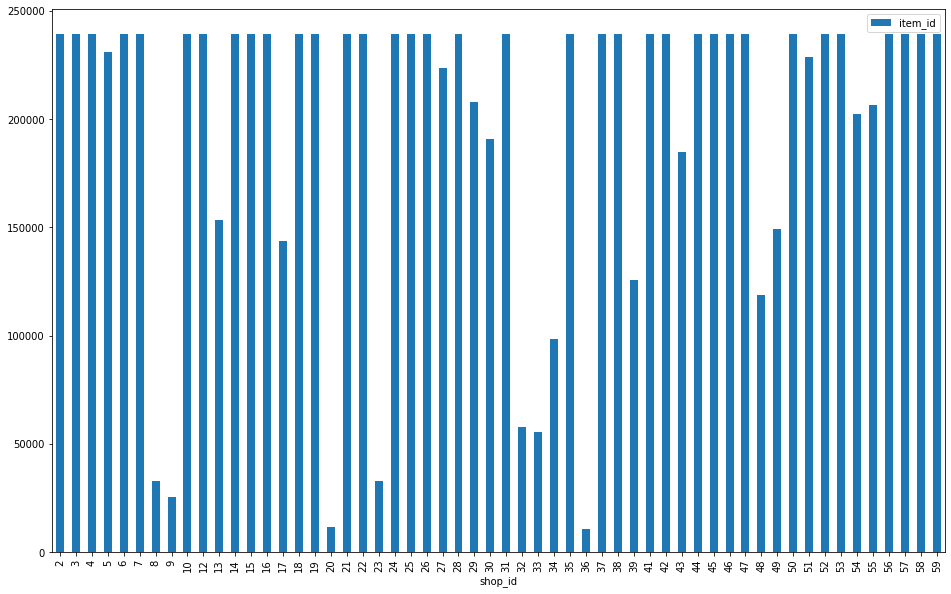

In [26]:
all_data.groupby('shop_id').agg({'item_id': 'count'}).plot.bar(figsize=(16, 10))

# Add new features

### Add calendar features

In [27]:
import math
import calendar
import holidays
import datetime

date_blocks = pd.DataFrame(all_data.date_block_num.drop_duplicates())

def add_month(col):
    return int(divmod(col, 12)[1] + 1)

def add_year(col):
    return int(2013 + divmod(col+1, 12)[0])

def add_year_month(row):
    return f'{row.year}-{row.month}'

def add_season(col):
    if 0 < col <= 2 or col == 12:
        return 'winter'
    if 3 <= col < 6:
        return 'spring'
    if 6 <= col < 9:
        return 'summer'
    if 9 <= col < 12:
        return 'autumn'
    return np.nan

# get number of holidays + weekend in each month    
ru_holidays = []

for date, name in sorted(holidays.RU(years=[2013, 2014, 2015]).items()):
    ru_holidays.append(date)
    
def add_holidays_and_weekends(row):
    busines_dates = pd.bdate_range(f"{row.year}-{row.month}-01", f"{row.year}-{row.month}-{row.days_in_month}")
    busines_dates = [b for b in busines_dates if b not in ru_holidays]
    return row.days_in_month - len(busines_dates)
    
def create_calendar_features(data):
    data['month'] = data.date_block_num.apply(add_month).astype(np.int8) 
    data['year'] = data.date_block_num.apply(add_year).astype(np.int16) 
    data['year_month'] = data.apply(add_year_month, axis=1)
    data.year_month = pd.to_datetime(data.year_month, format='%Y-%m')
    data['days_in_month'] = data.year_month.dt.daysinmonth.astype(np.int8) 
    data['season'] = data.month.apply(add_season) 
    data['holidays_and_weekends_in_month'] = data.apply(add_holidays_and_weekends, axis=1).astype(np.int8)
    data.drop(['year_month', 'year', 'month'], axis=1, inplace=True)


create_calendar_features(date_blocks)
date_blocks.head()

,date_block_num,days_in_month,season,holidays_and_weekends_in_month
0,0,31,winter,14
365175,1,28,winter,8
740903,2,31,spring,11
1122795,3,30,spring,8
1497465,4,31,spring,10


### Add geographical features

In [28]:
def add_city(col):
    city = col.split(' ')
    if city[0][0] == '!':
        return city[0][1:]
    if city[0] == 'Адыгея':
        return 'Краснодар'
    return city[0]


def add_shop_type(col):
    if 'ТЦ' in col:
        return 1
    if 'ТРЦ' in col or 'МТРЦ' in col:
        return 2
    if 'ТК' in col:
        return 3
    if 'ТРК' in col:
        return 4
    for c in ['Якутск Орджоникидзе', 'Жуковский', 'Воронеж (Плехановская, 13)', 'Магазин С21']:
        if c in col:
            return 5
    return 0


# add features
shops['city'] = shops.shop_name.apply(add_city)

shops['shop_type'] = shops.shop_name.apply(add_shop_type)

# downcast types
shops.shop_type = shops.shop_type.astype(np.int8)
shops = downcast_dtypes(shops)

shops.head()

,shop_name,shop_id,city,shop_type
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,5
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,1
2,"Адыгея ТЦ ""Мега""",2,Краснодар,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,4
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1


### Add expert features for items and shops

In [29]:
def add_global_category(col):
    cat = col.split(' ')
    if cat[0] == 'Игровые':
        return 'Игровые консоли'
    if cat[0] == 'Карты':
        return 'Карты оплаты'
    if cat[0] == 'Чистые':
        return 'Чистые носители'
    if cat[0] == 'Элементы':
        return 'Элементы питания'
    if cat[0] == 'Доставка':
        return 'Доставка товара'
    return cat[0]

def add_platform(col):
    platform_list = ['PS', 'XBOX', 'PC', 'Android', 'MAC', 'Windows', '1С', 'Blu-Ray',
                    'CD', 'DVD', 'MP3']
    for platform in platform_list:
        if platform in col:
            return platform
    return 'None'

def add_digital(col):
    if 'Цифра' in col:
        return 1
    return 0

def clean_item_name(string):
    # Removes bracketed terms, special characters and extra whitespace
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

# add items
items['item_name_cleaned_length'] = items.item_name.apply(clean_item_name).apply(len)
items['item_name_length'] = items.item_name.apply(len)

item_categories['global_category'] = item_categories.item_category_name.apply(add_global_category)
# item_categories['platform'] = item_categories.item_category_name.apply(add_platform)
# item_categories['is_digital'] = item_categories.item_category_name.apply(add_digital)

# downcast types
items.item_category_id = items.item_category_id.astype(np.int8)
items.item_name_cleaned_length = items.item_name_cleaned_length.astype(np.int16)
items.item_name_length = items.item_name_length.astype(np.int16)
items = downcast_dtypes(items)

item_categories.item_category_id = item_categories.item_category_id.astype(np.int16)
# item_categories.is_digital = item_categories.is_digital.astype(np.int32)
 
items.head()

,item_name,item_id,item_category_id,item_name_cleaned_length,item_name_length
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,29,41
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,64,68
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,19,45
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,20,47
4,***КОРОБКА (СТЕКЛО) D,4,40,16,43


In [30]:
item_categories.head()

,item_category_name,item_category_id,global_category
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


### Add data from other datasets to train and test datasets

Train dataset

In [31]:
all_data = all_data.join(items.set_index('item_id'), on='item_id')
all_data = all_data.join(item_categories.set_index('item_category_id'), on='item_category_id')
all_data = all_data.join(shops.set_index('shop_id'), on='shop_id')
all_data = all_data.join(date_blocks.set_index('date_block_num'), on='date_block_num')

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,sale_days_in_month,item_deals_month,item_price,first_day,last_day,item_name,item_category_id,item_name_cleaned_length,item_name_length,item_category_name,global_category,shop_name,city,shop_type,days_in_month,season,holidays_and_weekends_in_month
0,0,2,19,0.0,0.0,0.0,0.0,0.0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,22,25,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14
1,0,2,27,1.0,1.0,1.0,2499.0,11.0,11.0,"007 Legends [PS3, русская версия]",19,30,33,Игры - PS3,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14
2,0,2,28,0.0,0.0,0.0,0.0,0.0,0.0,"007 Legends [PС, Jewel, русская версия]",30,35,39,Игры PC - Стандартные издания,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14
3,0,2,29,0.0,0.0,0.0,0.0,0.0,0.0,"007 Legends [Xbox 360, русская версия]",23,35,38,Игры - XBOX 360,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14
4,0,2,32,0.0,0.0,0.0,0.0,0.0,0.0,1+1,40,2,3,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14


In [32]:
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,sale_days_in_month,item_deals_month,item_price,first_day,last_day,item_name,item_category_id,item_name_cleaned_length,item_name_length,item_category_name,global_category,shop_name,city,shop_type,days_in_month,season,holidays_and_weekends_in_month
0,0,2,19,0.0,0.0,0.0,0.0,0.0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,22,25,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14
1,0,2,27,1.0,1.0,1.0,2499.0,11.0,11.0,"007 Legends [PS3, русская версия]",19,30,33,Игры - PS3,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14
2,0,2,28,0.0,0.0,0.0,0.0,0.0,0.0,"007 Legends [PС, Jewel, русская версия]",30,35,39,Игры PC - Стандартные издания,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14
3,0,2,29,0.0,0.0,0.0,0.0,0.0,0.0,"007 Legends [Xbox 360, русская версия]",23,35,38,Игры - XBOX 360,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14
4,0,2,32,0.0,0.0,0.0,0.0,0.0,0.0,1+1,40,2,3,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14


### Add feature that shows how many days ago item was sold before by current shop

In [33]:
%%time
from tqdm.auto import tqdm

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

# dictionary for storing of the last date_block for current item in current shop
ids_dict = dict()

def get_prev_sales(row):
    shop_id, item_id, item_cnt_month, last_day, days_in_month = row.shop_id, row.item_id, row.item_cnt_month, row.last_day, row.days_in_month
    if (shop_id, item_id) in ids_dict:
        res = ids_dict[(shop_id, item_id)]
        if item_cnt_month != 0:
            ids_dict[(shop_id, item_id)] = days_in_month - last_day + 1
        else:
            ids_dict[(shop_id, item_id)] += days_in_month
    else:
        res = 0
        ids_dict[(shop_id, item_id)] = days_in_month - last_day + 1
    return res

   
all_data['last_saled_days_ago'] = all_data.progress_apply(get_prev_sales, axis=1).astype(np.float32)
all_data.drop(['first_day', 'last_day'], axis=1, inplace=True)

all_data.head()

  0%|          | 0/11056323 [00:00<?, ?it/s]

CPU times: user 4min 11s, sys: 3.11 s, total: 4min 14s
Wall time: 4min 13s


,date_block_num,shop_id,item_id,item_cnt_month,sale_days_in_month,item_deals_month,item_price,item_name,item_category_id,item_name_cleaned_length,item_name_length,item_category_name,global_category,shop_name,city,shop_type,days_in_month,season,holidays_and_weekends_in_month,last_saled_days_ago
0,0,2,19,0.0,0.0,0.0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,22,25,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0
1,0,2,27,1.0,1.0,1.0,2499.0,"007 Legends [PS3, русская версия]",19,30,33,Игры - PS3,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0
2,0,2,28,0.0,0.0,0.0,0.0,"007 Legends [PС, Jewel, русская версия]",30,35,39,Игры PC - Стандартные издания,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0
3,0,2,29,0.0,0.0,0.0,0.0,"007 Legends [Xbox 360, русская версия]",23,35,38,Игры - XBOX 360,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0
4,0,2,32,0.0,0.0,0.0,0.0,1+1,40,2,3,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0


### Add sum/mean encoded features

In [34]:
def create_gr_feats(data):
    # create aggregation feats for numeric features based on categorical ones
    for cat_col in ['shop_id', 'item_category_id', 'item_id', 'global_category']:
        # create_col_with_min_freq(data, cat_col, 15,)
        data['sum_' + 'item_cnt_month' + 
             '_by_' + cat_col] = all_data.groupby(['date_block_num', 
                                                   cat_col])['item_cnt_month'].transform(np.sum).astype(np.float32)
        data['mean_' + 'item_price' + 
             '_by_' + cat_col] = all_data.groupby(['date_block_num', 
                                                   cat_col])['item_price'].transform(np.mean).astype(np.float32)

create_gr_feats(all_data)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,sale_days_in_month,item_deals_month,item_price,item_name,item_category_id,item_name_cleaned_length,item_name_length,item_category_name,global_category,shop_name,city,shop_type,days_in_month,season,holidays_and_weekends_in_month,last_saled_days_ago,sum_item_cnt_month_by_shop_id,mean_item_price_by_shop_id,sum_item_cnt_month_by_item_category_id,mean_item_price_by_item_category_id,sum_item_cnt_month_by_item_id,mean_item_price_by_item_id,sum_item_cnt_month_by_global_category,mean_item_price_by_global_category
0,0,2,19,0.0,0.0,0.0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,22,25,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,1146.0,80.15345,33488.0,35.657887,1.0,0.622222,43001.0,54.498623
1,0,2,27,1.0,1.0,1.0,2499.0,"007 Legends [PS3, русская версия]",19,30,33,Игры - PS3,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,1146.0,80.15345,8983.0,471.525421,7.0,361.666656,46514.0,292.597900
2,0,2,28,0.0,0.0,0.0,0.0,"007 Legends [PС, Jewel, русская версия]",30,35,39,Игры PC - Стандартные издания,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,1146.0,80.15345,22216.0,127.125778,8.0,61.000000,46514.0,292.597900
3,0,2,29,0.0,0.0,0.0,0.0,"007 Legends [Xbox 360, русская версия]",23,35,38,Игры - XBOX 360,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,1146.0,80.15345,4150.0,465.084625,4.0,208.600006,46514.0,292.597900
4,0,2,32,0.0,0.0,0.0,0.0,1+1,40,2,3,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,1146.0,80.15345,33488.0,35.657887,299.0,275.479248,43001.0,54.498623


### Add lagged item_cnt features

In [35]:
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,sale_days_in_month,item_deals_month,item_price,item_name,item_category_id,item_name_cleaned_length,item_name_length,item_category_name,global_category,shop_name,city,shop_type,days_in_month,season,holidays_and_weekends_in_month,last_saled_days_ago,sum_item_cnt_month_by_shop_id,mean_item_price_by_shop_id,sum_item_cnt_month_by_item_category_id,mean_item_price_by_item_category_id,sum_item_cnt_month_by_item_id,mean_item_price_by_item_id,sum_item_cnt_month_by_global_category,mean_item_price_by_global_category
0,0,2,19,0.0,0.0,0.0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,22,25,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,1146.0,80.15345,33488.0,35.657887,1.0,0.622222,43001.0,54.498623
1,0,2,27,1.0,1.0,1.0,2499.0,"007 Legends [PS3, русская версия]",19,30,33,Игры - PS3,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,1146.0,80.15345,8983.0,471.525421,7.0,361.666656,46514.0,292.597900
2,0,2,28,0.0,0.0,0.0,0.0,"007 Legends [PС, Jewel, русская версия]",30,35,39,Игры PC - Стандартные издания,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,1146.0,80.15345,22216.0,127.125778,8.0,61.000000,46514.0,292.597900
3,0,2,29,0.0,0.0,0.0,0.0,"007 Legends [Xbox 360, русская версия]",23,35,38,Игры - XBOX 360,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,1146.0,80.15345,4150.0,465.084625,4.0,208.600006,46514.0,292.597900
4,0,2,32,0.0,0.0,0.0,0.0,1+1,40,2,3,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,1146.0,80.15345,33488.0,35.657887,299.0,275.479248,43001.0,54.498623


In [36]:
%%time

index_cols = ['date_block_num', 'shop_id', 'item_id']

# add feature that shows how many days in month item was sold
all_data['sale_days_ratio'] = all_data.sale_days_in_month/all_data.days_in_month
all_data.drop('sale_days_in_month', axis=1, inplace=True)

target_cols = [c for c in all_data.columns if c.startswith('sum_item_cnt', 0, 13)] + ['item_cnt_month', 
                                                                                      'sale_days_ratio', 
                                                                                      'item_deals_month']

def create_item_cnt_lagged_features():
    global all_data
    win = [1, 2, 3]
    for w in tqdm_notebook(win):
        
        tmp = all_data[index_cols + target_cols].copy()
        
        tmp.date_block_num = tmp.date_block_num + w
        
        foo = lambda x: f'{x}_lag_{w}' if x in target_cols else x
        tmp.rename(columns=foo, inplace=True)

        all_data = all_data.join(tmp.set_index(index_cols), on=index_cols)
        
        del tmp
        gc.collect()

        
create_item_cnt_lagged_features()

# drop all mean encoded columns, except item_cnt_month
target_cols.remove('item_cnt_month')
all_data.drop(target_cols, axis=1, inplace=True)

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 15.4 s, sys: 4.72 s, total: 20.1 s
Wall time: 20.1 s


In [37]:
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_name,item_category_id,item_name_cleaned_length,item_name_length,item_category_name,global_category,shop_name,city,shop_type,days_in_month,season,holidays_and_weekends_in_month,last_saled_days_ago,mean_item_price_by_shop_id,mean_item_price_by_item_category_id,mean_item_price_by_item_id,mean_item_price_by_global_category,sum_item_cnt_month_by_shop_id_lag_1,sum_item_cnt_month_by_item_category_id_lag_1,sum_item_cnt_month_by_item_id_lag_1,sum_item_cnt_month_by_global_category_lag_1,item_cnt_month_lag_1,sale_days_ratio_lag_1,item_deals_month_lag_1,sum_item_cnt_month_by_shop_id_lag_2,sum_item_cnt_month_by_item_category_id_lag_2,sum_item_cnt_month_by_item_id_lag_2,sum_item_cnt_month_by_global_category_lag_2,item_cnt_month_lag_2,sale_days_ratio_lag_2,item_deals_month_lag_2,sum_item_cnt_month_by_shop_id_lag_3,sum_item_cnt_month_by_item_category_id_lag_3,sum_item_cnt_month_by_item_id_lag_3,sum_item_cnt_month_by_global_category_lag_3,item_cnt_month_lag_3,sale_days_ratio_lag_3,item_deals_month_lag_3
0,0,2,19,0.0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,22,25,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,80.15345,35.657887,0.622222,54.498623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,2499.0,"007 Legends [PS3, русская версия]",19,30,33,Игры - PS3,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,80.15345,471.525421,361.666656,292.597900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,"007 Legends [PС, Jewel, русская версия]",30,35,39,Игры PC - Стандартные издания,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,80.15345,127.125778,61.000000,292.597900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,"007 Legends [Xbox 360, русская версия]",23,35,38,Игры - XBOX 360,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,80.15345,465.084625,208.600006,292.597900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,1+1,40,2,3,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,80.15345,35.657887,275.479248,54.498623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add lagged item_price features

In [38]:
%%time

target_cols = [c for c in all_data.columns if c.startswith('mean_item_price', 0, 15)]

def create_item_price_lagged_features():
    global all_data
    win = [1, 2, 3]
    for w in tqdm_notebook(win):
        
        tmp = all_data[index_cols + target_cols].copy()
        
        tmp.date_block_num = tmp.date_block_num + w
        
        foo = lambda x: f'{x}_lag_{w}' if x in target_cols else x
        tmp.rename(columns=foo, inplace=True)

        all_data = all_data.join(tmp.set_index(index_cols), on=index_cols)
        
        del tmp
        gc.collect()


create_item_price_lagged_features()

all_data.drop(target_cols + ['item_price'], axis=1, inplace=True)

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 14.9 s, sys: 4.62 s, total: 19.5 s
Wall time: 19.5 s


### Add time statistics (mean, mode, min, max, std, EWM, difference, etc.)

In [39]:
%%time

def add_time_statistics(data):
    for win in tqdm_notebook([2, 3]):
        cols = get_window(data, win)
        tmp = data[cols]
        
        data[f'{win}_month_mean_cnt'] = tmp.mean(axis=1).astype(np.float32)
        data[f'{win}_month_median_cnt'] = tmp.median(axis=1).astype(np.float32)
        data[f'{win}_month_min_cnt'] = np.nanmin(tmp, axis=1).astype(np.float32)
        data[f'{win}_month_max_cnt'] = np.nanmax(tmp, axis=1).astype(np.float32)
        data[f'{win}_month_std_cnt'] = tmp.std(axis=1).astype(np.float32)

        # add exponential weighted mean (EWM)
        data[f'mean_ewm_prev_{win}'] = tmp.T.ewm(com=9.5).mean().T.mean(axis=1).astype(np.float32)
        data[f'last_ewm_prev_{win}'] = tmp.T.ewm(com=9.5).mean().T.iloc[:,-1].astype(np.float32)

        # add difference between data points
#         data[f'avg_diff_{win}'] = (tmp - tmp.shift(1, axis=1)).mean(axis=1).astype(np.float32)
        
            
def get_window(data, w):
    cols = []
    col_num = 1
    for i in data.columns:
        if col_num > w:
            break
        if i == f'item_cnt_month_lag_{col_num}':
            cols.append(i)
            col_num += 1
    return cols

add_time_statistics(all_data)

  0%|          | 0/2 [00:00<?, ?it/s]

<timed exec>:8: RuntimeWarning: All-NaN axis encountered
<timed exec>:9: RuntimeWarning: All-NaN axis encountered
<timed exec>:8: RuntimeWarning: All-NaN axis encountered
<timed exec>:9: RuntimeWarning: All-NaN axis encountered


CPU times: user 3min 27s, sys: 1.6 s, total: 3min 28s
Wall time: 3min 28s


### Feature interactions: add number of sales for closest item IDs

In [40]:
%%time

index_cols = ['date_block_num', 'shop_id', 'item_id']

def add_closest_ids(win):
    global all_data

    target_cols = [f'item_cnt_month_lag_{w}' for w in win]
    
    # add previous sales of items with next id
    tmp = all_data[index_cols + target_cols].copy()

    tmp.item_id = tmp.item_id + 1

    foo = lambda x: f'{x}_prev_id' if x in target_cols else x
    tmp.rename(columns=foo, inplace=True)

    all_data = all_data.join(tmp.set_index(index_cols), on=index_cols)
    
    del tmp
    gc.collect()
    
    # add previous sales of items with previous id
    tmp = all_data[index_cols + target_cols].copy()
    
    tmp.item_id = tmp.item_id - 1

    foo = lambda x: f'{x}_next_id' if x in target_cols else x
    tmp.rename(columns=foo, inplace=True)

    all_data = all_data.join(tmp.set_index(index_cols), on=index_cols)

    del tmp
    gc.collect()

# drop all mean encoded columns, except item_cnt_month
add_closest_ids([1, 2, 3])

CPU times: user 9.7 s, sys: 2.8 s, total: 12.5 s
Wall time: 12.5 s


### Save file

In [41]:
all_data.to_hdf('all_data.h5', key='df')

# Train model

### Load file

In [42]:
import gc
import numpy as np
import pandas as pd
import multiprocessing as mp
from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# all_data = pd.read_hdf('all_data.h5', key='df')

# Prepare dataset for model training

### Drop unnecessary rows and columns

In [43]:
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_name_cleaned_length,item_name_length,item_category_name,global_category,shop_name,city,shop_type,days_in_month,season,holidays_and_weekends_in_month,last_saled_days_ago,sum_item_cnt_month_by_shop_id_lag_1,sum_item_cnt_month_by_item_category_id_lag_1,sum_item_cnt_month_by_item_id_lag_1,sum_item_cnt_month_by_global_category_lag_1,item_cnt_month_lag_1,sale_days_ratio_lag_1,item_deals_month_lag_1,sum_item_cnt_month_by_shop_id_lag_2,sum_item_cnt_month_by_item_category_id_lag_2,sum_item_cnt_month_by_item_id_lag_2,sum_item_cnt_month_by_global_category_lag_2,item_cnt_month_lag_2,sale_days_ratio_lag_2,item_deals_month_lag_2,sum_item_cnt_month_by_shop_id_lag_3,sum_item_cnt_month_by_item_category_id_lag_3,sum_item_cnt_month_by_item_id_lag_3,sum_item_cnt_month_by_global_category_lag_3,item_cnt_month_lag_3,sale_days_ratio_lag_3,item_deals_month_lag_3,mean_item_price_by_shop_id_lag_1,mean_item_price_by_item_category_id_lag_1,mean_item_price_by_item_id_lag_1,mean_item_price_by_global_category_lag_1,mean_item_price_by_shop_id_lag_2,mean_item_price_by_item_category_id_lag_2,mean_item_price_by_item_id_lag_2,mean_item_price_by_global_category_lag_2,mean_item_price_by_shop_id_lag_3,mean_item_price_by_item_category_id_lag_3,mean_item_price_by_item_id_lag_3,mean_item_price_by_global_category_lag_3,2_month_mean_cnt,2_month_median_cnt,2_month_min_cnt,2_month_max_cnt,2_month_std_cnt,mean_ewm_prev_2,last_ewm_prev_2,3_month_mean_cnt,3_month_median_cnt,3_month_min_cnt,3_month_max_cnt,3_month_std_cnt,mean_ewm_prev_3,last_ewm_prev_3,item_cnt_month_lag_1_prev_id,item_cnt_month_lag_2_prev_id,item_cnt_month_lag_3_prev_id,item_cnt_month_lag_1_next_id,item_cnt_month_lag_2_next_id,item_cnt_month_lag_3_next_id
0,0,2,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,22,25,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,"007 Legends [PS3, русская версия]",19,30,33,Игры - PS3,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,"007 Legends [PС, Jewel, русская версия]",30,35,39,Игры PC - Стандартные издания,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,"007 Legends [Xbox 360, русская версия]",23,35,38,Игры - XBOX 360,Игры,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,1+1,40,2,3,Кино - DVD,Кино,"Адыгея ТЦ ""Мега""",Краснодар,1,31,winter,14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12]

all_data.drop(['shop_name','item_name', 'item_category_name'], axis=1, inplace=True)

### Encode text features with label encoder.

In [45]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cols = ['city', 'season', 'global_category']
all_data[cols] = all_data[cols].apply(LabelEncoder().fit_transform)
all_data[cols] = all_data[cols].astype(np.int8)

### Clip target value, fill NaNs

In [46]:
all_data.item_cnt_month.clip(0, 20, inplace=True)

all_data.fillna(0, inplace=True)

# Validate model

In [47]:
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_name_cleaned_length,item_name_length,global_category,city,shop_type,days_in_month,season,holidays_and_weekends_in_month,last_saled_days_ago,sum_item_cnt_month_by_shop_id_lag_1,sum_item_cnt_month_by_item_category_id_lag_1,sum_item_cnt_month_by_item_id_lag_1,sum_item_cnt_month_by_global_category_lag_1,item_cnt_month_lag_1,sale_days_ratio_lag_1,item_deals_month_lag_1,sum_item_cnt_month_by_shop_id_lag_2,sum_item_cnt_month_by_item_category_id_lag_2,sum_item_cnt_month_by_item_id_lag_2,sum_item_cnt_month_by_global_category_lag_2,item_cnt_month_lag_2,sale_days_ratio_lag_2,item_deals_month_lag_2,sum_item_cnt_month_by_shop_id_lag_3,sum_item_cnt_month_by_item_category_id_lag_3,sum_item_cnt_month_by_item_id_lag_3,sum_item_cnt_month_by_global_category_lag_3,item_cnt_month_lag_3,sale_days_ratio_lag_3,item_deals_month_lag_3,mean_item_price_by_shop_id_lag_1,mean_item_price_by_item_category_id_lag_1,mean_item_price_by_item_id_lag_1,mean_item_price_by_global_category_lag_1,mean_item_price_by_shop_id_lag_2,mean_item_price_by_item_category_id_lag_2,mean_item_price_by_item_id_lag_2,mean_item_price_by_global_category_lag_2,mean_item_price_by_shop_id_lag_3,mean_item_price_by_item_category_id_lag_3,mean_item_price_by_item_id_lag_3,mean_item_price_by_global_category_lag_3,2_month_mean_cnt,2_month_median_cnt,2_month_min_cnt,2_month_max_cnt,2_month_std_cnt,mean_ewm_prev_2,last_ewm_prev_2,3_month_mean_cnt,3_month_median_cnt,3_month_min_cnt,3_month_max_cnt,3_month_std_cnt,mean_ewm_prev_3,last_ewm_prev_3,item_cnt_month_lag_1_prev_id,item_cnt_month_lag_2_prev_id,item_cnt_month_lag_3_prev_id,item_cnt_month_lag_1_next_id,item_cnt_month_lag_2_next_id,item_cnt_month_lag_3_next_id
4488756,12,2,27,0.0,19,30,33,5,10,1,31,3,14,355.0,1322.0,15818.0,4.0,64316.0,0.0,0.000000,0.0,862.0,9030.0,2.0,49477.0,0.0,0.000000,0.0,795.0,14113.0,6.0,50676.0,0.0,0.0,0.0,83.221458,444.437775,91.130432,280.493652,59.491615,450.741119,53.244446,259.566895,64.190727,431.824524,122.904350,242.599030,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4488757,12,2,30,0.0,40,23,26,7,10,1,31,3,14,199.0,1322.0,28598.0,47.0,42496.0,0.0,0.000000,0.0,862.0,25433.0,46.0,35509.0,0.0,0.000000,0.0,795.0,24173.0,24.0,33497.0,0.0,0.0,0.0,83.221458,30.312819,79.120651,51.846855,59.491615,27.333755,84.746666,42.409489,64.190727,26.232250,97.382607,39.761314,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4488758,12,2,31,0.0,37,26,31,7,10,1,31,3,14,264.0,1322.0,9959.0,25.0,42496.0,0.0,0.000000,0.0,862.0,7420.0,27.0,35509.0,0.0,0.000000,0.0,795.0,6950.0,25.0,33497.0,0.0,0.0,0.0,83.221458,56.378319,195.260864,51.846855,59.491615,47.473106,183.616302,42.409489,64.190727,46.273113,248.741302,39.761314,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4488759,12,2,32,1.0,40,2,3,7,10,1,31,3,14,366.0,1322.0,28598.0,89.0,42496.0,0.0,0.000000,0.0,862.0,25433.0,81.0,35509.0,0.0,0.000000,0.0,795.0,24173.0,58.0,33497.0,0.0,0.0,0.0,83.221458,30.312819,98.642395,51.846855,59.491615,27.333755,102.666664,42.409489,64.190727,26.232250,109.710144,39.761314,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,2.0,0.0
4488760,12,2,33,1.0,37,5,8,7,10,1,31,3,14,4.0,1322.0,9959.0,42.0,42496.0,1.0,0.032258,1.0,862.0,7420.0,15.0,35509.0,2.0,0.033333,2.0,795.0,6950.0,33.0,33497.0,0.0,0.0,0.0,83.221458,56.378319,98.152176,51.846855,59.491615,47.473106,56.111111,42.409489,64.190727,46.273113,101.613045,39.761314,1.5,1.5,1.0,2.0,0.707107,1.2625,1.525,1.0,1.0,0.0,2.0,1.0,1.163343,0.965029,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
cat_feats = [#'date_block_num',
             #'shop_id',
             #'item_id',
             'item_category_id',
             'city',
             'global_category', 
             'season']

last_block = 33
dates = all_data['date_block_num']

cols_to_drop = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']

# split dataset on train and test sets for model training
X_train = all_data.loc[dates <  last_block].drop(cols_to_drop, axis=1)
X_val = all_data.loc[dates ==  last_block].drop(cols_to_drop, axis=1)
X_test = all_data.loc[dates ==  34].drop(cols_to_drop, axis=1)

y_train = all_data.loc[dates <  last_block, 'item_cnt_month']
y_val = all_data.loc[dates ==  last_block, 'item_cnt_month']

lgb_params = {
            'objective': 'mse',
            'metric': 'rmse',
            'num_leaves': 32,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 1
        }

# fit LGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

gbm = lgb.train(
        lgb_params, 
        lgb_train,
        num_boost_round=500,
        valid_sets=(lgb_train, lgb_eval),
        categorical_feature=cat_feats,
        verbose_eval=50, 
        early_stopping_rounds = 50)

test_pred_lgb = gbm.predict(X_test)

/home/alex/.local/lib/python3.8/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city', 'global_category', 'item_category_id', 'season']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.856789	valid_1's rmse: 0.923052
[100]	training's rmse: 0.826334	valid_1's rmse: 0.920796
[150]	training's rmse: 0.810407	valid_1's rmse: 0.917384
[200]	training's rmse: 0.799188	valid_1's rmse: 0.913401
[250]	training's rmse: 0.790941	valid_1's rmse: 0.912246
[300]	training's rmse: 0.783422	valid_1's rmse: 0.911521
[350]	training's rmse: 0.778514	valid_1's rmse: 0.909992
[400]	training's rmse: 0.774309	valid_1's rmse: 0.909745
[450]	training's rmse: 0.770213	valid_1's rmse: 0.90952
[500]	training's rmse: 0.76575	valid_1's rmse: 0.908628
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.76575	valid_1's rmse: 0.908628


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

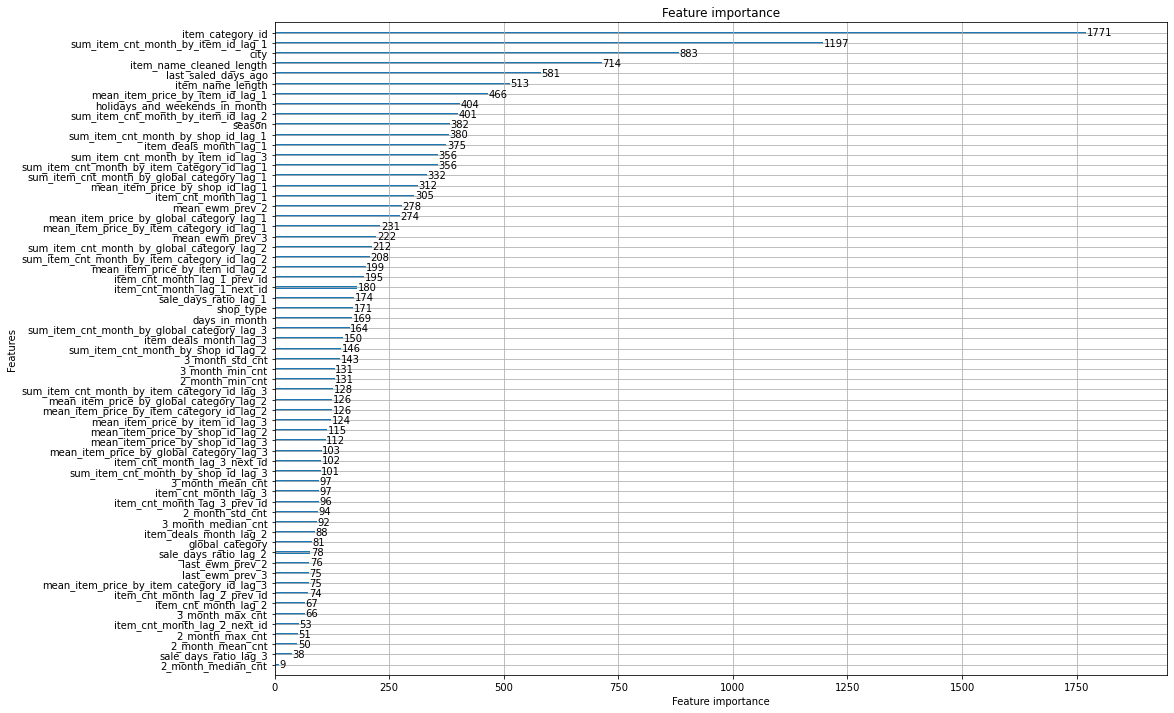

In [49]:
lgb.plot_importance(gbm, figsize=(16, 12))

In [50]:
feat_importance = dict(zip(X_train.columns, gbm.feature_importance()))
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda x: x[1], reverse=True)}


# Save predictions

In [51]:
import os

submission = pd.read_csv("sample_submission.csv.zip")
submission['item_cnt_month'] = test_pred_lgb
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.head(10)

,ID,item_cnt_month
0,0,0.022809
1,1,0.189133
2,2,0.238596
3,3,0.194758
4,4,0.008844
5,5,0.000125
6,6,0.000125
7,7,0.000491
8,8,0.005466
9,9,0.000000


In [52]:
b

NameError: name 'b' is not defined

In [ ]:
submission.to_csv('submission_lgb.csv', index=False)

In [ ]:
cat_feats = [#'date_block_num',
             #'shop_id',
             #'item_id',
             'item_category_id',
             'city',
             'global_category', 
             'platform',
             'season']

cols_to_drop = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']

dates = all_data['date_block_num']

In [ ]:
cat_feats = [#'date_block_num',
             #'shop_id',
             #'item_id',
             'item_category_id',
             'city',
             'global_category', 
             'platform',
             'season']

val_scores = list()

cols_to_drop = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']

# for block in [31, 32, 33]:
last_block = 33
dates = all_data['date_block_num']

# split dataset on train and test sets for model training
X_train = all_data.loc[dates <  last_block].drop(cols_to_drop, axis=1)
X_val = all_data.loc[dates ==  last_block].drop(cols_to_drop, axis=1)

y_train = all_data.loc[dates <  last_block, 'item_cnt_month']
y_val = all_data.loc[dates ==  last_block, 'item_cnt_month']

# fit CatBoost
cbr = CatBoostRegressor(iterations=500, 
                        learning_rate=0.05, 
                        loss_function='RMSE',
                        metric_period = 100,
                        task_type="GPU",
                        devices='0:1'
                    )
cbr.fit(
    X_train, y_train,
    cat_features = cat_feats,
    eval_set=(X_val, y_val),
#         logging_level='Silent',
#         plot=True
)
    
#     val_scores.append(cbr.get_best_score()['validation']['RMSE'])
    
# print(f'Validation mean score is {np.mean(val_scores)}')

# Predict

In [ ]:
# save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
last_block = 34

# split dataset on train and test sets for model training
X_train = all_data.loc[dates <  last_block].drop(cols_to_drop, axis=1)
y_train = all_data.loc[dates <  last_block, 'item_cnt_month']

X_test = all_data.loc[dates ==  last_block].drop(cols_to_drop, axis=1)

# fit CatBoost
cbr = CatBoostRegressor(
                      iterations=500, 
                      learning_rate=0.05 
                      loss_function='RMSE',
                      metric_period = 100,
                      task_type="GPU",
                      devices='0:1'
                    )

cbr.fit(
    X_train, y_train,
    cat_features = cat_feats,
)

test_pred_cbr = cbr.predict(X_test)

In [ ]:
cbr.get_feature_importance(prettified=True)

In [ ]:
sales_train2.head()

In [ ]:
sales_test2.head()

# Train model ensemble

### Load data files

In [ ]:
import gc
import numpy as np
import pandas as pd
import multiprocessing as mp
from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

sales_train2 = pd.read_hdf('sales_train2.h5', key='df')
sales_test2 = pd.read_hdf('sales_test2.h5', key='df')

sales_train2.head()

### Split dataset on train, validation and test sets

In [ ]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
last_block = 34
dates = sales_train2['date_block_num']
# save dates to use them to split dataset on train and test later
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

# split dataset on train and test sets for model training
X_train = sales_train2.loc[dates <  last_block].drop('item_cnt_month', axis=1)
X_test = sales_test2.copy()

y_train = sales_train2.loc[dates <  last_block, 'item_cnt_month']

del sales_train2
gc.collect()

### Save train, validation and test datasets to files

In [ ]:
# X_train.to_hdf('X_train.h5', key='df')
# X_val.to_hdf('X_val.h5', key='df')
# X_test.to_hdf('X_test.h5', key='df')

# y_train.to_hdf('y_train.h5', key='df')
# y_val.to_hdf('y_val.h5', key='df')

### Load train and test datasets from files

In [ ]:
# X_train = pd.read_hdf('X_train.h5', key='df')
# X_val = pd.read_hdf('X_val.h5', key='df')
# X_test = pd.read_hdf('X_test.h5', key='df')

# y_train = pd.read_hdf('y_train.h5', key='df')
# y_val = pd.read_hdf('y_val.h5', key='df')

# Train model ensemble

We decide to train LGBM and CatBoost models. We also tried to used linear regression, KNN, random forests and extra trees, but linear regression just can't produce the same quality results as boost models can and all other models are too sloooow for training. So we postpone ensembling with them and now try to ensemble two boosting models.

### Create test meta-features

In [ ]:
cat_feats = ['shop_id',
             'item_category_id',
             'city',
             'global_category', 
             'platform',
             'season']

# fit CatBoost
cbr = CatBoostRegressor(
                      iterations=500, 
                      learning_rate=0.05, 
                      loss_function='RMSE',
                      cat_features = cat_feats,
                      metric_period = 50
                    )
cbr.fit(X_train, y_train)
test_pred_cbr = cbr.predict(X_test)

lgb_params = {
            'objective': 'mse',
            'metric': 'rmse',
            'num_leaves': 32,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 1
        }

 # fit LGBM
lgb_train = lgb.Dataset(X_train, y_train)

gbm = lgb.train(
        lgb_params, 
        lgb_train,
        num_boost_round=500,
        valid_sets=lgb_train, 
        categorical_feature=cat_feats,
        verbose_eval=50, 
        early_stopping_rounds = 50)

test_pred_lgb = gbm.predict(X_test)

Concatenate two predictions to get test meta-features

In [ ]:
X_test_level2 = np.c_[test_pred_cbr, test_pred_lgb] 

### Create train meta-features

In [ ]:
dates_train_level2 = dates_train[dates_train.isin([30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([30, 31, 32, 33])]

# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

meta_index_begin = 0
meta_index_end = 0

# Now fill `X_train_level2` with metafeatures
for cur_block_num in tqdm_notebook([30, 31, 32, 33]):
    
    # split data
    train_index = X_train.loc[dates <  cur_block_num].index
    val_index  = X_train.loc[dates == cur_block_num].index
    
    x_train_ = X_train.loc[X_train.index.isin(train_index), :]
    x_val_ =  X_train.loc[X_train.index.isin(val_index), :]

    y_train_ = y_train.loc[y_train.index.isin(train_index)].values
    y_val_ =  y_train.loc[y_train.index.isin(val_index)].values
    
    meta_index_end += y_val_.shape[0]
    
    # fit CatBoost
    cbr = CatBoostRegressor(
                          iterations=500, 
                          learning_rate=0.05, 
                          loss_function='RMSE',
                          cat_features = cat_feats,
                          metric_period = 50
                        )
    cbr.fit(x_train_, y_train_, eval_set=(x_val_, y_val_))
    pred_cbr = cbr.predict(x_val_)
    
    X_train_level2[meta_index_begin:meta_index_end, 0] = pred_cbr
    
    # fit LGBM
    lgb_train = lgb.Dataset(x_train_, y_train_)
    lgb_eval = lgb.Dataset(x_val_, y_val_, reference=lgb_train)
    
    gbm = lgb.train(
            lgb_params, 
            lgb_train,
            num_boost_round=500,
            valid_sets=(lgb_train, lgb_eval), 
            categorical_feature=cat_feats,
            verbose_eval=50, 
            early_stopping_rounds = 50)
    
    pred_lgb = gbm.predict(x_val_)
    
    X_train_level2[meta_index_begin:meta_index_end, 1] = pred_lgb
    
    meta_index_begin = meta_index_end

### Simple convex mix

In [ ]:
alphas_to_try = np.linspace(0, 1, 1001)
   
best_alpha = 0
mse_train_simple_mix = np.inf

for alpha in alphas_to_try:
    mse_mix = mean_squared_error(y_train_level2, alpha*X_train_level2[:, 0] + (1-alpha)*X_train_level2[:, 1])
    if mse_mix < mse_train_simple_mix:
        mse_train_simple_mix = mse_mix
        best_alpha = alpha

print(f'Best alpha: {best_alpha}; Corresponding MSE on train: {mse_train_simple_mix}')

Save meta-features

In [ ]:
np.save('X_train_level2.npy', X_train_level2)
np.save('X_test_level2.npy', X_test_level2)
np.save('y_train_level2.npy', y_train_level2)

# Prediction

### Load meta-features

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

X_train_level2 = np.load('X_train_level2.npy')
X_test_level2 = np.load('X_test_level2.npy')
y_train_level2 = np.load('y_train_level2.npy')

### Predict for the test set with convex mix

In [ ]:
best_alpha = 0.324

test_preds = best_alpha*X_test_level2[:, 0] + (1-best_alpha)*X_test_level2[:, 1]

### Save predictions to the submission file

In [ ]:
submission = pd.read_csv("sample_submission.csv.zip")
submission['item_cnt_month'] = test_preds
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.head(10)

In [ ]:
submission.to_csv('submission_simple_convex_mix.csv', index=False)

### Stacking

In [ ]:
X_train_level2.shape

In [ ]:
y_train_level2.shape

In [ ]:
# fit linear regression
lr = LinearRegression()
lr.fit(X_train_level2, y_train_level2)

test_preds = lr.predict(X_test_level2)

### Save stacking predictions to file

In [ ]:
submission['item_cnt_month'] = test_preds
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.to_csv('submission_stacking.csv', index=False)

submission.head(10)

- Simple convex combination gives us 0.9022 LB score.
- Stacking gives us 0.9023 LB score.
- One finely tuned LGBM model gives us 0.9068 score.

So, even simple stacking with similar model gives us performance boost. 

But there are a lot of space to work with: generate additional features; more complex ensembles with KNN, SVD, RF, ET, NN; additional hyperparameter optimization, etc. We definitely try all of this to imrove the LB score and hit the top.

# Optimize with Optuna

In [ ]:
import optuna.integration.lightgbm as lgb

params = {
    'objective': 'mse',
    'learning_rate': 0.005,
    'metric': 'rmse',
    'verbose': 1
}
cat_feats = ['item_category_id',
             'city',
             'global_category', 
             'platform',
             'season']

# lgb_train = lgb.Dataset(x[feature_name], y)
lgb_train = lgb.Dataset(X_train, y_train)

lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

evals_result = dict()

gbm = lgb.train(
        params, 
        lgb_train,
        valid_sets=(lgb_train, lgb_eval), 
#         valid_sets=lgb_train,
        categorical_feature = cat_feats,
        verbose_eval=50, 
        evals_result = evals_result,
        early_stopping_rounds = 50)

In [ ]:
gbm.params

Feature importance

In [ ]:
lgb.plot_importance(gbm, figsize=(16, 12))

Model learning curve

In [ ]:
lgb.plot_metric(evals_result)

# Make prediction

In [ ]:
y = gbm.predict(X_test)

submission = pd.read_csv("sample_submission.csv.zip")
submission['item_cnt_month'] = y
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.head(10)

# Save to file

In [ ]:
submission.to_csv('submission_lgb_tuned.csv', index=False)

# Futher ideas

- add text description



# Use LightAutoML to predict sales

In [ ]:
import os
import logging

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import multiprocessing as mp

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

In [ ]:
N_THREADS = mp.cpu_count()
N_FOLDS = 10
RANDOM_STATE = 42
TIMEOUT = 2*3600
TARGET_NAME = 'item_price'


task = Task('reg', loss='mse', metric='mse')
roles = {
    'target': TARGET_NAME
}


In [ ]:
automl = TabularUtilizedAutoML(task=task,
                               timeout=TIMEOUT,
                               cpu_limit=N_THREADS,
                               general_params={'use_algos':
                                                  [['lgb', 'linear_l2', 'cb'],
                                                   ['lgb_tuned'],
                                                   ]},
                               reader_params={'cv': N_FOLDS,
                                             'random_state': RANDOM_STATE,
                                             'n_jobs': N_THREADS},
                               timing_params = {'mode': 0}
                          ) 


oof_pred = automl.fit_predict(X_train, roles=roles)


In [ ]:
y = automl.predict(sales_test2)

submission['item_cnt_month'] = y
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.head(10)

In [ ]:
submission.to_csv('submission.csv', index=False)

Fit KNN

In [ ]:
# %%time

# knn = KNeighborsRegressor(n_jobs=mp.cpu_count())
# knn.fit(X_train.values, y_train.values)
# pred_knn = knn.predict(X_val.values) # there was X_test, restart this string

# # save file 
# np.save('pred_knn.npy', pred_knn)

Fit extra trees

In [ ]:
# %%time

# etr = ExtraTreesRegressor(verbose=1, n_jobs=mp.cpu_count())
# etr.fit(X_train.values, y_train.values)
# pred_etr = etr.predict(X_val.values)

# # save file 
# np.save('pred_etr.npy', pred_etr)

Fit random forest

In [ ]:
# %%time

# rfr = RandomForestRegressor(verbose=1, n_jobs=mp.cpu_count())
# rfr.fit(X_train.values, y_train.values)
# pred_rfr = rfr.predict(X_val.values)

# # save file 
# np.save('pred_rfr.npy', pred_rfr)